## Loading the dataset and visualiztions

In [1]:
# importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Parent directory where images are stored in drive
parent_dir = '/content/drive/MyDrive/brain_tumor'

# Path to the training and testing datasets within the parent directory
train_dir = os.path.join(parent_dir, 'Training')
validation_dir = os.path.join(parent_dir, 'Testing')

# Directory with our training pictures
train_pituitary_dir = os.path.join(train_dir, 'pituitary_tumor')
train_no_dir = os.path.join(train_dir, 'no_tumor')

# Directory with our testing pictures
validation_pituitary_dir = os.path.join(validation_dir, 'pituitary_tumor')
validation_no_dir = os.path.join(validation_dir, 'no_tumor')

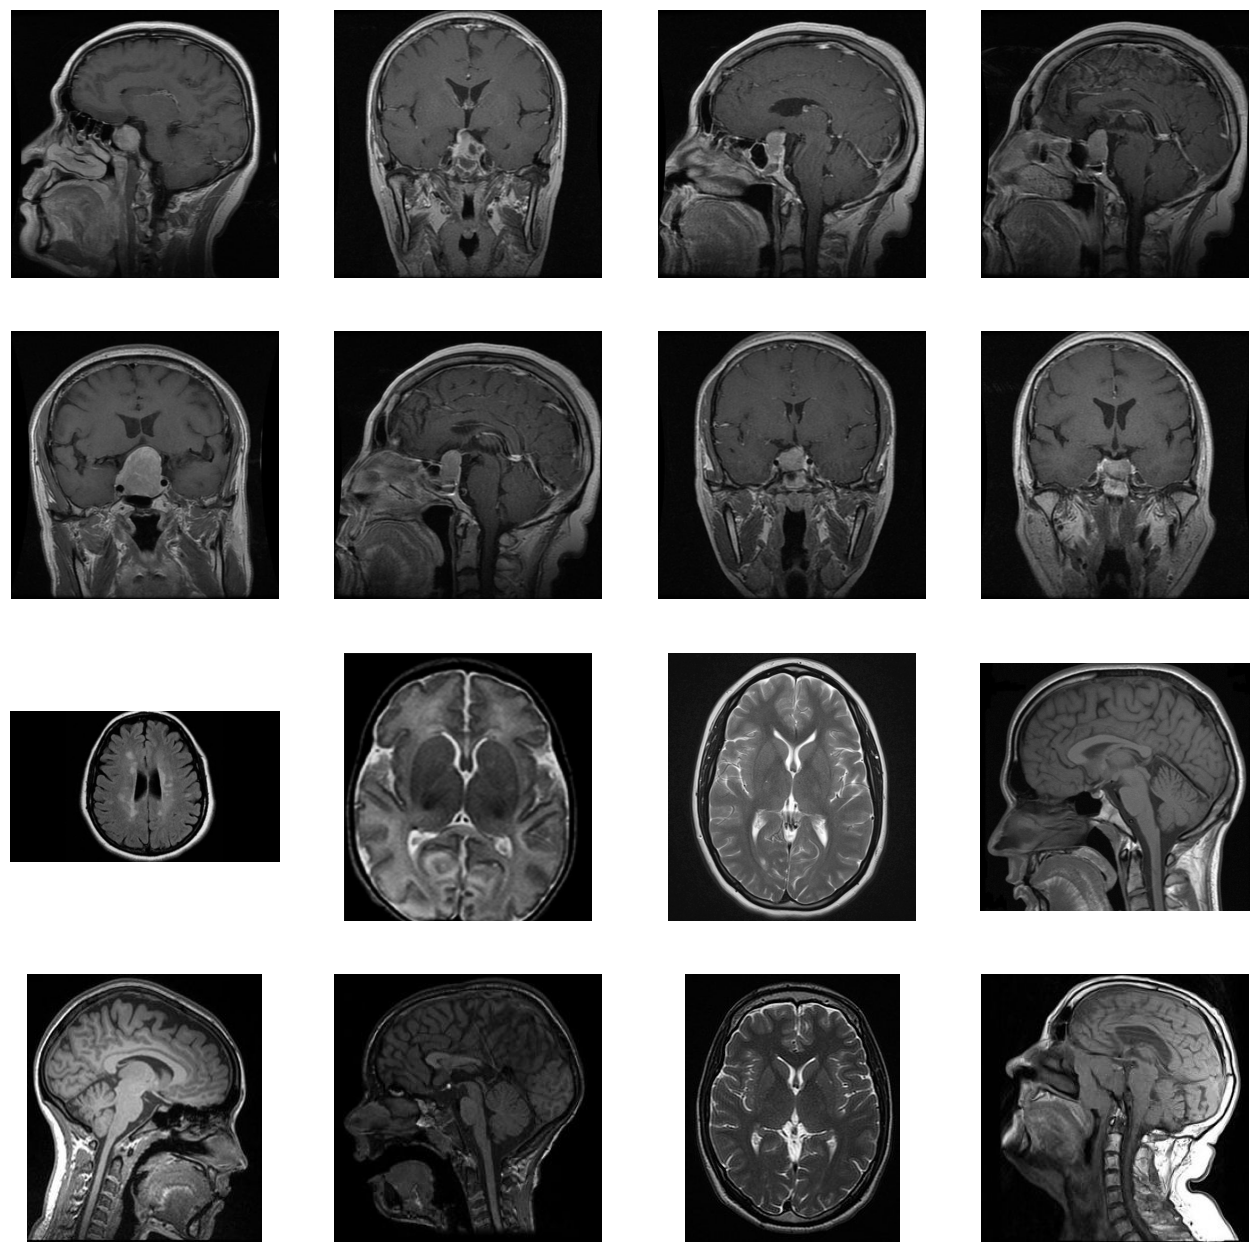

In [4]:
#Visualization of images before data preprocessing

train_pituitary_file_names = os.listdir(train_pituitary_dir)
train_no_file_names = os.listdir(train_no_dir)

fig = plt.figure(figsize=(16, 8))
fig.set_size_inches(16, 16)

pituitary_img_paths = [os.path.join(train_pituitary_dir, file_name) for file_name in train_pituitary_file_names[:8]]
no_img_paths = [os.path.join(train_no_dir, file_name) for file_name in train_no_file_names[:8]]

for i, img_path in enumerate(pituitary_img_paths + no_img_paths):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

It is noted that all the images are not of the same size, hence during the pre processing of the data, we will have to make sure to crop the images to make them all of the same size.

##Data Augmentation

In [5]:
# Data Augmentation, we can take the labels from the directory names

# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.1,
                              width_shift_range=0.1,
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.1)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

# Flowing testing images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (224, 224))

Found 830 images belonging to 2 classes.
Found 170 images belonging to 2 classes.


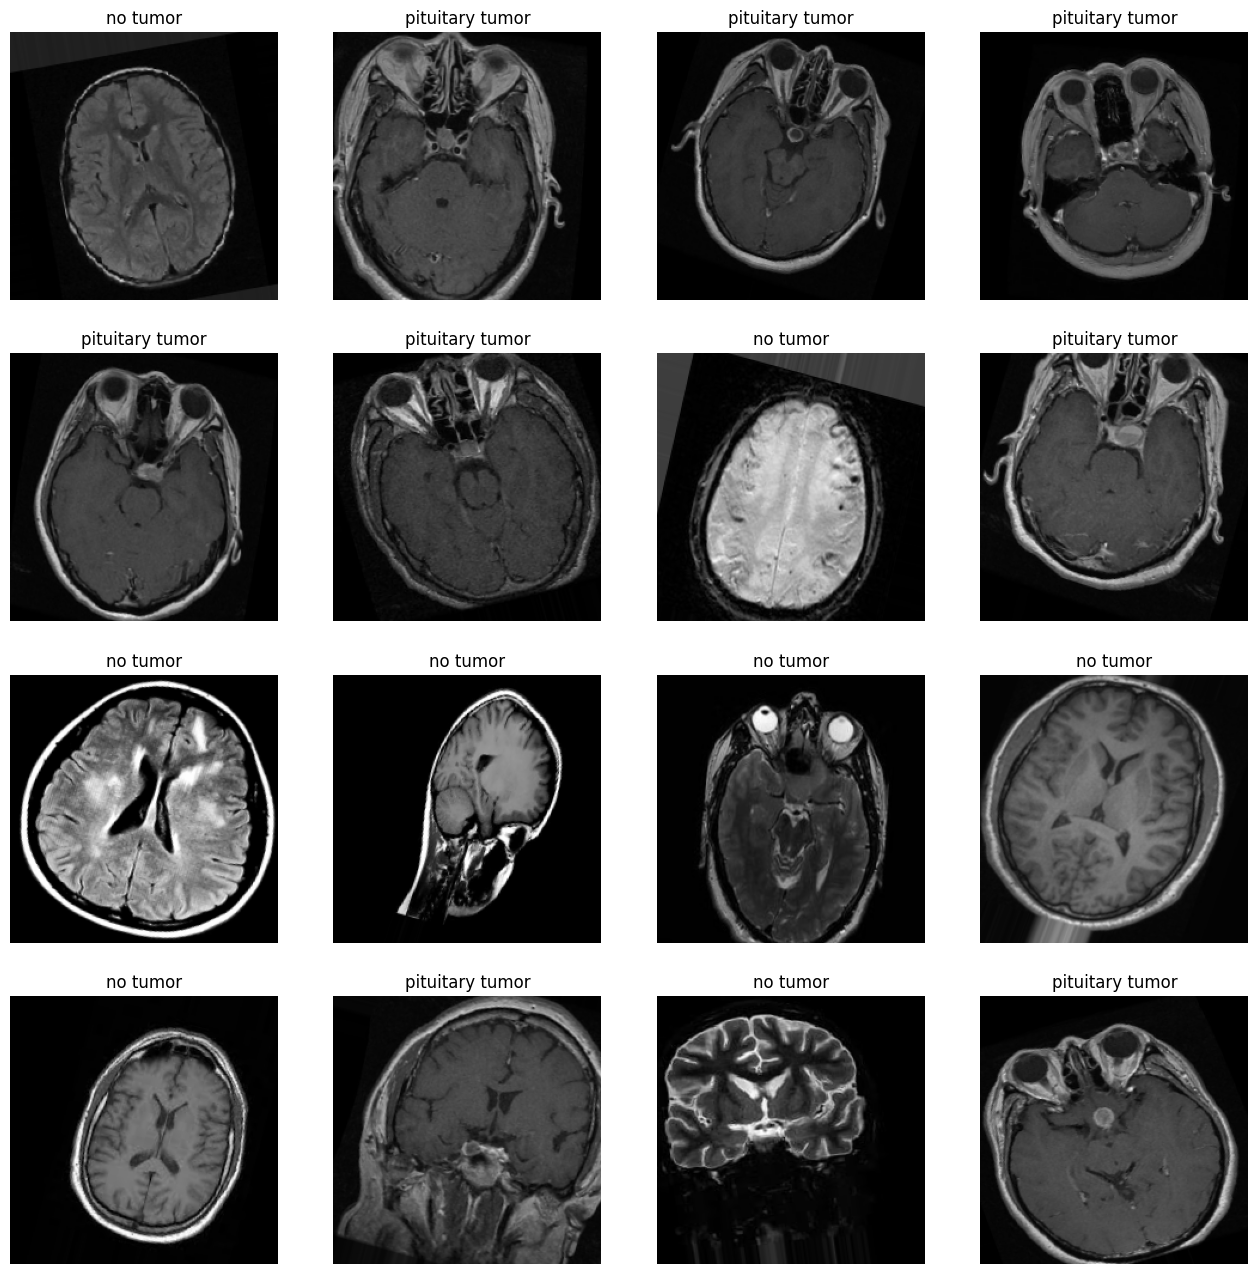

In [6]:
#visualizing again for seeing the changes

images, labels = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label == 1:
        ax.set_title('pituitary tumor')
    else:
        ax.set_title('no tumor')
    ax.axis('off')

##CNN MODEL BUILDING

In [7]:
cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3), padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3,3), activation='relu', padding = 'same'))
cnn_model.add(MaxPooling2D(2,2))
cnn_model.add(Conv2D(16, (3,3), activation='relu', padding = 'same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)




> Note for the architecture: It is focusing on learning via depth rather width, to make it deployable on edge of teh systems like embedded medical devices for preliminary diagnosis \ moreover it is done to reduce computation resources consumptions and run the model locally.\ Also because the dataset size is purposely chosen to be small

Hence it 64 -> 32 -> 16 aka reducing the no of filters even though its deeper in the network



In [8]:
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 840,561 (3.21 MB)

 Trainable params: 840,369 (3.21 MB)

 Non-trainable params: 192 (768.00 B)

In [9]:
testX,testY = next(validation_generator)

In [ ]:
# Pulling a single large batch of random testing data for testing after each epoch
testX, testY = next(validation_generator)

In [10]:
model_history = cnn_model.fit(train_generator,
                              validation_data=(testX, testY),
                              epochs=10)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 263s 6s/step - accuracy: 0.7178 - loss: 0.5706 - val_accuracy: 0.5000 - val_loss: 0.6473
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.8154 - loss: 0.4860 - val_accuracy: 0.4500 - val_loss: 0.7297
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8367 - loss: 0.3707 - val_accuracy: 0.3500 - val_loss: 1.8896
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.8579 - loss: 0.3415 - val_accuracy: 0.3500 - val_loss: 1.1077
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9106 - loss: 0.2710 - val_accuracy: 0.4500 - val_loss: 0.9200
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9231 - loss: 0.2326 - val_accuracy: 0.3500 - val_loss: 0.9064
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.9212 - loss: 0.2144 - val_accuracy: 0.4500 - val_loss: 0.8367
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.8839 - loss: 0.2540 - val_accuracy: 0.8000 - v

In [11]:
# Evaluating on the Test dataset
cnn_model.evaluate(validation_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.6642 - loss: 0.9279


[1.0106693506240845, 0.6705882549285889]

Conclusion: the no of trainable parameters are quite compared to usual benchmark numbers, around `850k`, which explains the low accuracy on the unseen data. Concluding that the model has overfit.

Next course of action: Use pre-trained model to not only save computation resources but also increase the model accuracy. For this project, `*VGG16*` is used.

In [12]:
from keras.applications.vgg16 import VGG16

# Summary of the whole model
model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# triming from the top to sustain all the learning
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [14]:
vgg_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [16]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [17]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

In [18]:
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_16 (Functional)      │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       802,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,518,625 (59.20 MB)

 Trainable params: 803,937 (3.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [19]:
## Fitting the VGG model
new_model_history = new_model.fit(train_generator,
                                  validation_data=(testX, testY),
                                  epochs=5)

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 552s 13s/step - accuracy: 0.7731 - loss: 0.5178 - val_accuracy: 0.8500 - val_loss: 0.3846
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 554s 13s/step - accuracy: 0.9599 - loss: 0.1098 - val_accuracy: 0.8500 - val_loss: 0.2797
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 542s 13s/step - accuracy: 0.9856 - loss: 0.0594 - val_accuracy: 0.9000 - val_loss: 0.2283
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 562s 13s/step - accuracy: 0.9836 - loss: 0.0500 - val_accuracy: 0.9500 - val_loss: 0.2113
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 553s 13s/step - accuracy: 0.9758 - loss: 0.0743 - val_accuracy: 0.8500 - val_loss: 0.4587


In [20]:
# Evaluating on the Test set
new_model.evaluate(validation_generator)

9/9 ━━━━━━━━━━━━━━━━━━━━ 106s 12s/step - accuracy: 0.8562 - loss: 0.5940


[0.655717134475708, 0.8470588326454163]

Now the accuracy has increased to `85%` from previously `66%`.

In [21]:
# Function to plot loss, val_loss,
def plot_history(history):
    N = len(history.history["accuracy"])
    plt.figure()
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training accuracy Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("accuracy")
    plt.legend(loc="upper right")


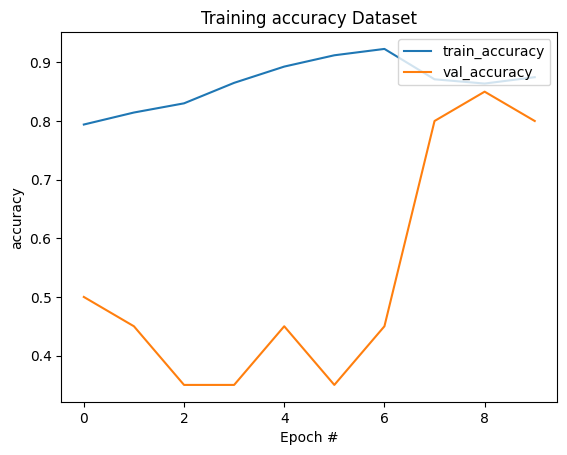

In [22]:
# Plotting the loss vs epoch curve for the basic CNN model without Transfer Learning
plot_history(model_history)

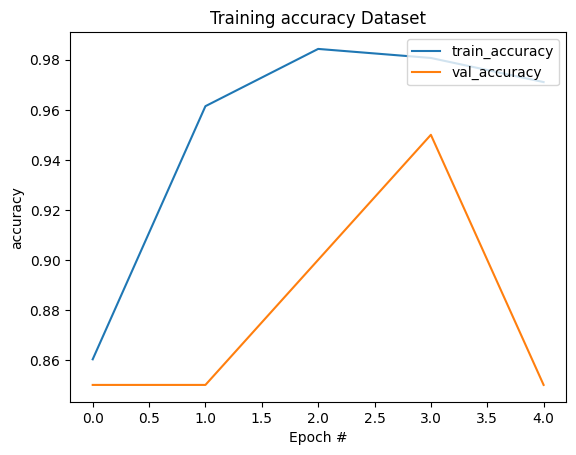

In [23]:
# Plotting the loss vs epoch curve for the Transfer Learning model
plot_history(new_model_history)

## **Conclusions**

- The difference in both models is evident. Both models had nearly the same number of trainable parameters. However even after training the custom CNN model for 10 epochs, it could not attain accuracies as high as we achieved with Transfer Learning.

- The Transfer Learning model has converged faster than the custom CNN model in only 5 epochs.

- That's a good level of improvement just by directly using a pre-trained architecture such as VGG16.

- This model can, in fact, further be tuned to achieve the accuracies required for practical applicability in the medical domain.